In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn import svm
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import ShuffleSplit

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
def preprocess(data):
    content = data['Content'].copy()
    n_articles = len(content)
    lemmatized_article_lst = []
    
    stop_words = list(stopwords.words('english'))
    wordnet_lemmatizer = WordNetLemmatizer()
    
    content = content.str.replace('\r', ' ')
    content = content.str.replace('\n', ' ')
    content = content.str.replace('    ', ' ')
    content = content.str.lower()
    
    for sign in ['"', ':', ';', '.', ',', '!', '?', "'s"]:
        content = content.str.replace(sign, '')
    
    for i_article in range(n_articles):
        lemmatized_lst = []
        article = content.loc[i_article]
        words = article.split(' ')
        for word in words:
            lemmatized_lst.append(wordnet_lemmatizer.lemmatize(word, pos='v'))
        lemmatized_article = ' '.join(lemmatized_lst)
        lemmatized_article_lst.append(lemmatized_article)
    
    content = pd.Series(lemmatized_article_lst)
    
    for stop_word in stop_words:
        regex_stopword = r'\b' + stop_word + r'\b'
        content = content.str.replace(regex_stopword, '')
    return content

# Import, preprocess and vectorization

In [3]:
data = pd.read_excel('News_dataset.xlsx')
data.head()

,File_Name,Content,Category,Complete_Filename
0,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,business,001.txt-business
1,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,business,002.txt-business
2,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,business,003.txt-business
3,004.txt,High fuel prices hit BA's profits\n\nBritish A...,business,004.txt-business
4,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,business,005.txt-business


In [4]:
X = preprocess(data)

In [5]:
data.Category.unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [6]:
codes = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [7]:
df = pd.DataFrame({'content': X, 'cat': data.Category, 
                   'code':data.Category.apply(lambda x: codes[x])})
df.head()

,content,cat,code
0,ad sales boost time warner profit quarterly p...,business,0
1,dollar gain greenspan speech dollar hit h...,business,0
2,yukos unit buyer face loan claim owners emb...,business,0
3,high fuel price hit ba profit british airways...,business,0
4,pernod takeover talk lift domecq share uk dr...,business,0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['content'], 
                                                    df['code'], 
                                                    test_size=0.3, 
                                                    random_state=89)

In [9]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=(1,2),
                        lowercase=False,
                        max_df=1.,
                        min_df=10,
                        max_features=300,
                        sublinear_tf=True)
                        
X_train = tfidf.fit_transform(X_train).toarray()
print(X_train.shape)

X_test = tfidf.transform(X_test).toarray()
print(X_test.shape)

(1557, 300)
(668, 300)


# Dimensionality reduction

In [10]:
X = np.concatenate((X_train,X_test), axis=0)
y = np.concatenate((y_train,y_test), axis=0)

## PCA

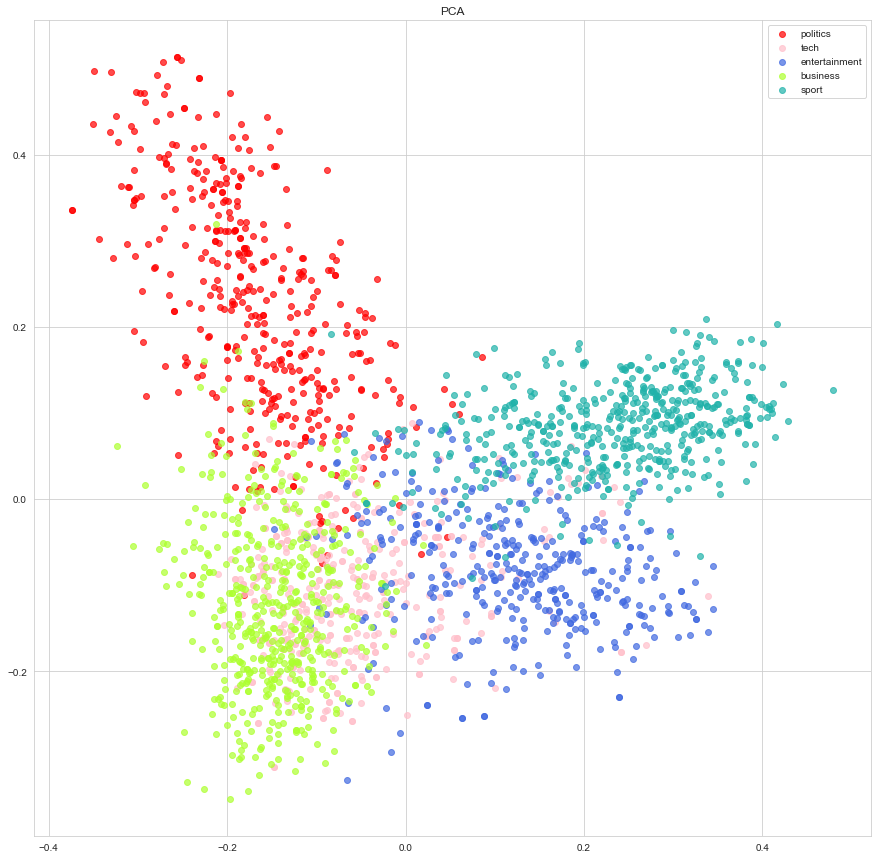

In [11]:
cats = {"0": 'business', "1": 'entertainment', "2": 'politics', "3": 'sport', "4": 'tech'}
colors = ["red", "pink", "royalblue", "greenyellow", "lightseagreen"]

mod = PCA(n_components=2)
pс = mod.fit_transform(X)
df_PCA = pd.DataFrame(data=pс, columns=['PC1', 'PC2'])
df_PCA['code'] = y
df_PCA['code'] = df_PCA['code'].astype(str)
df_PCA['cat'] = df_PCA['code']
df_PCA['cat'] = df_PCA['cat'].apply(lambda x: cats[x])
plt.figure(figsize=(15,15))
for cat, color in zip(df_PCA.cat.unique(), colors):
    temp = df_PCA[df_PCA['cat'] == cat]
    plt.scatter(temp.PC1, temp.PC2, c=color, label=cat, alpha=0.7)
plt.title('PCA')
plt.legend()     

## t-SNE

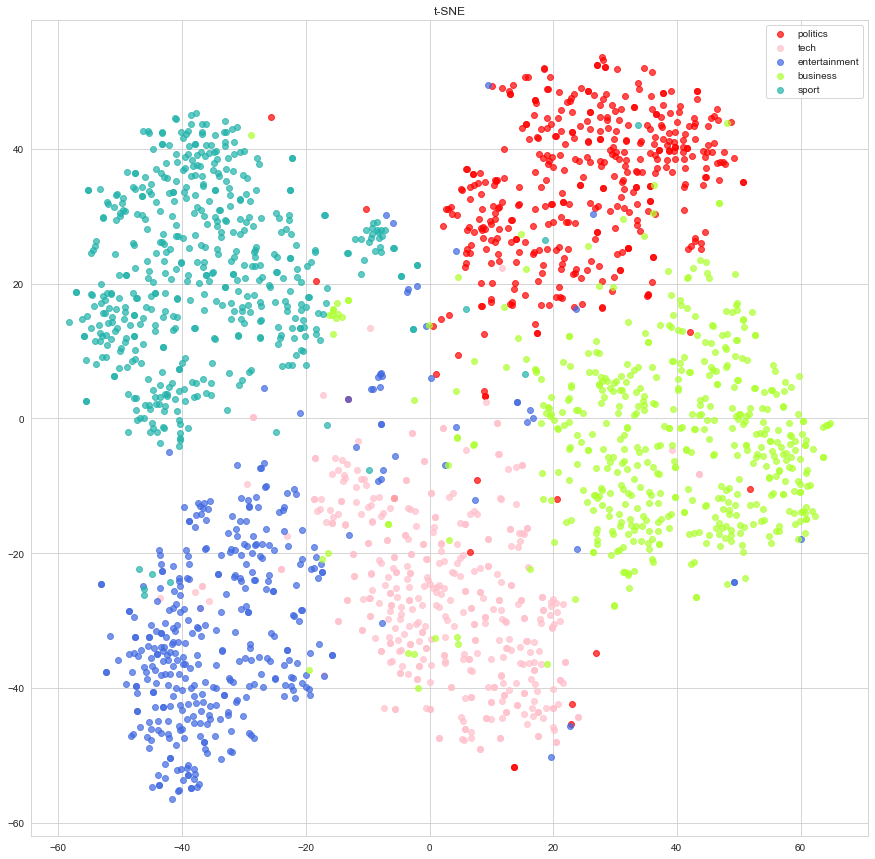

In [12]:
mod = TSNE(n_components=2, random_state=89)
pс = mod.fit_transform(X)
df_TSNE = pd.DataFrame(data=pс, columns=['PC1', 'PC2'])
df_TSNE['code'] = y
df_TSNE['code'] = df_TSNE['code'].astype(str)
df_TSNE['cat'] = df_TSNE['code']
df_TSNE['cat'] = df_TSNE['cat'].apply(lambda x: cats[x])

plt.figure(figsize=(15,15))
for cat, color in zip(df_TSNE.cat.unique(), colors):
    temp = df_TSNE[df_TSNE['cat'] == cat]
    plt.scatter(temp.PC1, temp.PC2, c=color, label=cat, alpha=0.7)
plt.title('t-SNE')
plt.legend()

In [13]:
Xtsne_train, Xtsne_test, ytsne_train, ytsne_test = train_test_split(df_TSNE[['PC1', 'PC2']], 
                                                    df_TSNE['code'].astype(int), 
                                                    test_size=0.3, 
                                                    random_state=89)

# SVM, RF, ET, LR

## Without t-SNE

## SVM 

### Random search


In [14]:
C = [0.0001, 0.001, 0.01]
gamma = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
degree = [1, 2, 3, 4, 5]
kernel = ['linear', 'rbf', 'poly']
probability = [True]

params = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

svc = svm.SVC(random_state=89)

random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=params,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=89)

random_search.fit(X_train, y_train)

print('Best params:')
print(random_search.best_params_)
print()
print('Best score:')
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.6min finished


Best params:
{'probability': True, 'kernel': 'poly', 'gamma': 100, 'degree': 2, 'C': 0.01}

Best score:
0.9646756583172769


### Grid search

In [15]:
C = [.0001, .001, .01, .1]
degree = [3, 4, 5]
gamma = [1, 10, 100]
probability = [True]

params = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]

svc = svm.SVC(random_state=89)

cv_sets = ShuffleSplit(n_splits=3, test_size=0.3, random_state=89)

grid_search = GridSearchCV(estimator=svc, 
                           param_grid=params,
                           scoring='accuracy',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

print('Best params:')
print(grid_search.best_params_)
print()
print('Best score:')
print(grid_search.best_score_)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  84 out of  84 | elapsed:  1.6min finished


Best params:
{'C': 0.1, 'kernel': 'linear', 'probability': True}

Best score:
0.9508547008547007


In [16]:
best_svc = grid_search.best_estimator_
best_svc

SVC(C=0.1, kernel='linear', probability=True, random_state=89)

## Random Forest

### Random search

In [17]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc = RandomForestClassifier(random_state=89)

random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=89)

random_search.fit(X_train, y_train)

print('Best params:')
print(random_search.best_params_)
print()
print('Best score:')
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  2.7min finished


Best params:
{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}

Best score:
0.9511881824020553


### Grid search

In [18]:
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [600]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

rfc = RandomForestClassifier(random_state=89)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state=89)

grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

print('Best params:')
print(grid_search.best_params_)
print()
print('Best score')
print(grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.8min finished


Best params:
{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 600}

Best score
0.9494163424124512


In [19]:
best_rfc = grid_search.best_estimator_
best_rfc

RandomForestClassifier(bootstrap=False, max_depth=30, max_features='sqrt',
                       min_samples_split=10, n_estimators=600, random_state=89)

## Extra Trees

### Random search

In [20]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

etc = ExtraTreesClassifier(random_state=89)

random_search = RandomizedSearchCV(estimator=etc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=89)

random_search.fit(X_train, y_train)

print('Best params:')
print(random_search.best_params_)
print()
print('Best score:')
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.8min finished


Best params:
{'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}

Best score:
0.9556840077071292


### Grid search

In [21]:
bootstrap = [False]
max_depth = [70, 80, 90]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [800]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

etc = ExtraTreesClassifier(random_state=89)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state=89)

grid_search = GridSearchCV(estimator=etc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

print('Best params:')
print(grid_search.best_params_)
print()
print('Best score:')
print(grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.5min finished


Best params:
{'bootstrap': False, 'max_depth': 70, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 800}

Best score:
0.9539559014267184


In [22]:
best_etc = grid_search.best_estimator_
best_etc

ExtraTreesClassifier(max_depth=70, max_features='sqrt', min_samples_split=5,
                     n_estimators=800, random_state=89)

## Logistic Regression

### Random search

In [23]:
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

multi_class = ['multinomial']

solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
class_weight = ['balanced', None]

penalty = ['l2']

random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

lrc = LogisticRegression(random_state=89)

random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=89)

random_search.fit(X_train, y_train)

print('Best params:')
print(random_search.best_params_)
print()
print('Best score:')
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    7.2s finished


Best params:
{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': None, 'C': 0.9}

Best score:
0.9550417469492615


### Grid search

In [24]:
C = [float(x) for x in np.linspace(start = 0.6, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['sag']
class_weight = ['balanced']
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

lrc = LogisticRegression(random_state=89)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state=89)

grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)

print('Best params:')
print(grid_search.best_params_)
print()
print('Best score:')
print(grid_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished


Best params:
{'C': 0.6, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'sag'}

Best score:
0.9571984435797666


In [25]:
best_lrc = grid_search.best_estimator_
best_lrc

LogisticRegression(C=0.6, class_weight='balanced', multi_class='multinomial',
                   random_state=89, solver='sag')

## With t-SNE

## SVM

### Random search

In [26]:
C = [.0001, .001, .01]
gamma = [.0001, .001, .01, .1, 1, 10, 100]
degree = [1, 2, 3, 4, 5]
kernel = ['linear']
probability = [True]

random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

svc = svm.SVC(random_state=89)

random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   n_jobs=-1,
                                   verbose=1, 
                                   random_state=89)

random_search.fit(Xtsne_train, ytsne_train)

print('Best params:')
print(random_search.best_params_)
print()
print('Best score:')
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.7s


Best params:
{'probability': True, 'kernel': 'linear', 'gamma': 1, 'degree': 3, 'C': 0.001}

Best score:
0.9177906229929351


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.9s finished


### Grid search

In [27]:
C = [0.001, 0.01, 0.1]
gamma = [0.001, 0.1, 1, 10, 100, 'auto', 'scale']
probability = [True]

param_grid = [{'C': C, 'kernel':['linear'], 'probability':probability, 'gamma':gamma}]

svc = svm.SVC(random_state=89)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 89)

grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(Xtsne_train, ytsne_train)

print('Best params:')
print(grid_search.best_params_)
print()
print('Best score:')
print(grid_search.best_score_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 21 candidates, totalling 63 fits
Best params:
{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear', 'probability': True}

Best score:
0.9163424124513618


[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    1.5s finished


In [28]:
best_svc_sne = grid_search.best_estimator_
best_svc_sne

SVC(C=0.01, gamma=0.001, kernel='linear', probability=True, random_state=89)

## Random forest

### Random search

In [29]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rfc = RandomForestClassifier(random_state=89)

random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=89)

random_search.fit(Xtsne_train, ytsne_train)

print('Best params:')
print(random_search.best_params_)
print()
print('Best score:')
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


Best params:
{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}

Best score:
0.943481053307643


### Grid search

In [30]:
bootstrap = [True]
max_depth = [50, 60, 70]
max_features = ['auto']
min_samples_leaf = [1, 2, 4]
min_samples_split = [5, 10, 15]
n_estimators = [700, 800, 900]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

rfc = RandomForestClassifier(random_state=89)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state=89)

grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(Xtsne_train, ytsne_train)

print('Best params:')
print(grid_search.best_params_)
print()
print('Best score:')
print(grid_search.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  2.5min finished


Best params:
{'bootstrap': True, 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 700}

Best score:
0.9396887159533073


In [31]:
best_rfc_sne = grid_search.best_estimator_
best_rfc_sne

RandomForestClassifier(max_depth=50, min_samples_split=5, n_estimators=700,
                       random_state=89)

## Extra Trees

### Random search

In [32]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

etc = ExtraTreesClassifier(random_state=89)

random_search = RandomizedSearchCV(estimator=etc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=89)

random_search.fit(Xtsne_train, ytsne_train)

print('Best params:')
print(random_search.best_params_)
print()
print('Best score:')
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   52.2s finished


Best params:
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}

Best score:
0.9428387925497752


### Grid search

In [33]:
bootstrap = [False]
max_depth = [30, 40, 50]
max_features = ['sqrt']
min_samples_leaf = [1, 2, 4]
min_samples_split = [2, 3, 5]
n_estimators = [400]

param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

etc = ExtraTreesClassifier(random_state=89)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state=89)

grid_search = GridSearchCV(estimator=etc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(Xtsne_train, ytsne_train)

print('Best params:')
print(grid_search.best_params_)
print()
print('Best score:')
print(grid_search.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   16.5s finished


Best params:
{'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}

Best score:
0.9409857328145265


In [34]:
best_etc_sne = grid_search.best_estimator_
best_etc_sne

ExtraTreesClassifier(max_depth=30, max_features='sqrt', n_estimators=400,
                     random_state=89)

## Logistic Regression

### Random search

In [35]:
C = [float(x) for x in np.linspace(start = 0.1, stop = 1, num = 10)]

multi_class = ['multinomial']

solver = ['newton-cg', 'sag', 'saga', 'lbfgs']
 
class_weight = ['balanced', None]

penalty = ['l2']

random_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

lrc = LogisticRegression(random_state=89)

random_search = RandomizedSearchCV(estimator=lrc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=89)

random_search.fit(Xtsne_train, ytsne_train)

print('Best params:')
print(random_search.best_params_)
print()
print('Best score:')
print(random_search.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s


Best params:
{'solver': 'lbfgs', 'penalty': 'l2', 'multi_class': 'multinomial', 'class_weight': 'balanced', 'C': 0.4}

Best score:
0.9120102761721259


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.5s finished
C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Grid search

In [36]:
C = [float(x) for x in np.linspace(start = 0.3, stop = 1, num = 10)]
multi_class = ['multinomial']
solver = ['lbfgs']
class_weight = ['balanced', None]
penalty = ['l2']

param_grid = {'C': C,
               'multi_class': multi_class,
               'solver': solver,
               'class_weight': class_weight,
               'penalty': penalty}

lrc = LogisticRegression(random_state=89)

cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state=89)

grid_search = GridSearchCV(estimator=lrc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(Xtsne_train, ytsne_train)

print('Best params:')
print(grid_search.best_params_)
print()
print('Best score:')
print(grid_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.4s finished


Best params:
{'C': 0.45555555555555555, 'class_weight': 'balanced', 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}

Best score:
0.9137483787289234


C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
best_lrc_sne = grid_search.best_estimator_
best_lrc_sne

LogisticRegression(C=0.45555555555555555, class_weight='balanced',
                   multi_class='multinomial', random_state=89)

# Results

In [47]:
models = [best_svc, best_rfc, best_etc, best_lrc]
models_sne = [best_svc_sne, best_rfc_sne, best_etc_sne, best_lrc_sne]
models_names = ['SVC Train', 'SVC Test', 'SVC t-SNE Train', 'SVC t-SNE Test',
                'RFC Train', 'RFC Test', 'RFC t-SNE Train', 'RFC t-SNE Test',
                'ETC Train', 'ETC Test', 'ETC t-SNE Train', 'ETC t-SNE Test',
                'LRC Train', 'LRC Test', 'LRC t-SNE Train', 'LRC t-SNE Test']
acc = []
prec = []
rec = []
f1 = []
roc = []
for model, model_sne in zip(models, models_sne):
    model.fit(X_train, y_train)
    model_sne.fit(Xtsne_train, ytsne_train)
    
    acc.append(accuracy_score(y_train, model.predict(X_train)))
    acc.append(accuracy_score(y_test, model.predict(X_test)))
    acc.append(accuracy_score(ytsne_train, model_sne.predict(Xtsne_train)))
    acc.append(accuracy_score(ytsne_test, model_sne.predict(Xtsne_test)))    
    
    prec.append(precision_score(y_train, model.predict(X_train),average='macro'))
    prec.append(precision_score(y_test, model.predict(X_test), average='macro'))
    prec.append(precision_score(ytsne_train, model_sne.predict(Xtsne_train), average='macro'))
    prec.append(precision_score(ytsne_test, model_sne.predict(Xtsne_test), average='macro')) 
    
    rec.append(recall_score(y_train, model.predict(X_train), average='macro'))
    rec.append(recall_score(y_test, model.predict(X_test), average='macro'))
    rec.append(recall_score(ytsne_train, model_sne.predict(Xtsne_train), average='macro'))
    rec.append(recall_score(ytsne_test, model_sne.predict(Xtsne_test), average='macro')) 
    
    f1.append(f1_score(y_train, model.predict(X_train), average='macro'))
    f1.append(f1_score(y_test, model.predict(X_test), average='macro'))
    f1.append(f1_score(ytsne_train, model_sne.predict(Xtsne_train), average='macro'))
    f1.append(f1_score(ytsne_test, model_sne.predict(Xtsne_test), average='macro')) 

res = pd.DataFrame({'Model':models_names, 'Accuracy':acc, 'Precision':prec, 'Recall':rec, 'F1':f1})
res

C:\Users\Nikita\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,Accuracy,Precision,Recall,F1
0,SVC Train,0.965318,0.965649,0.963704,0.964604
1,SVC Test,0.953593,0.957262,0.949906,0.952853
2,SVC t-SNE Train,0.917148,0.914899,0.914849,0.914581
3,SVC t-SNE Test,0.922156,0.921588,0.919390,0.920200
4,RFC Train,1.000000,1.000000,1.000000,1.000000
5,RFC Test,0.941617,0.944807,0.939463,0.941777
6,RFC t-SNE Train,0.987155,0.986432,0.987136,0.986739
7,RFC t-SNE Test,0.946108,0.945937,0.944880,0.945140
8,ETC Train,1.000000,1.000000,1.000000,1.000000
9,ETC Test,0.950599,0.953923,0.948704,0.950921
